In [1]:
import numpy as np
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as st
import pyforest
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width',1000)

In [2]:
loan=pd.read_csv('loan.csv')
loan1=loan.copy()
# impute gender with most freq category
loan1['Gender']=loan1['Gender'].fillna('Male')
# impute gender with most freq category
loan1['Dependents']=loan1['Dependents'].fillna('0')
# impute gender with most freq category
loan1['Self_Employed']=loan1['Self_Employed'].fillna('No')
# as the distribution is skewed, we'll do for median imputation
loan1['LoanAmount']=loan1['LoanAmount'].fillna(loan1['LoanAmount'].median())
# we'll do for mean imputation
loan1['Loan_Amount_Term']=loan1['Loan_Amount_Term'].fillna(loan1['Loan_Amount_Term'].mean())
# impute gender with most freq category
loan1['Credit_History']=loan1['Credit_History'].fillna(1.0)
# impute gender with most freq category
loan1['Married']=loan1['Married'].fillna('Yes')
# drop loanid
loan1.drop('Loan_ID',axis=1,inplace=True)

In [3]:
from sklearn.preprocessing import LabelEncoder
def le(df,col):
    lab=LabelEncoder()
    df[col]=pd.Series(lab.fit_transform(df[col]))

In [4]:
le(loan1,'Gender')
le(loan1,'Married')
le(loan1,'Dependents')
le(loan1,'Education')
le(loan1,'Self_Employed')
le(loan1,'Property_Area')
le(loan1,'Loan_Status')

In [5]:
from scipy.stats import zscore
z=np.abs(zscore(loan1))
loan1=loan1[(z<3).all(axis=1)]

x=loan1.drop('Loan_Status',axis=1)
y=loan1['Loan_Status']

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score,cross_val_predict,cross_validate
from sklearn.metrics import roc_curve, roc_auc_score

# Now, let's define some functions to reuse them
def fitc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    
def get_scorec(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    train_score=m.score(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return train_score,test_score

def get_predc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    return pred

def get_metricsc(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    acc=accuracy_score(pred,y_test)
    conf=confusion_matrix(pred,y_test)
    clas=classification_report(pred,y_test)
    return acc,conf,clas

from sklearn.model_selection import GridSearchCV
def gridcvc(m,p,x,y):
    gkb=GridSearchCV(m,p,n_jobs=-1,cv=5,scoring='accuracy')
    gkb.fit(x,y)
    return gkb.best_params_


from sklearn.model_selection import RandomizedSearchCV
def randomcvc(m,p,x,y):
    from sklearn.model_selection import RandomizedSearchCV
    gkb=RandomizedSearchCV(estimator=m,param_distributions=p,
                          cv=5,n_iter=75,
                          n_jobs=-1, verbose=5,return_train_score=True,random_state=45)
    gkb.fit(x,y)
    return gkb.best_params_

from mlxtend.feature_selection import SequentialFeatureSelector as sfs
def bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    return xbfe

def ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    return xffs

from sklearn.decomposition import PCA
def nforpcac(x):
    pca=PCA().fit(x)
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_)*100)
    plt.xlabel('No of Components')
    plt.ylabel('Variance')
    plt.axhline(y=95, color='r', linestyle='--')
    plt.show()
    
def pcac(m,x,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    return xpca

def crossc(m,x,y,c=5):
    score=cross_val_score(m,x,y,cv=c,n_jobs=-1)
    return (score.mean(), score.std())

from sklearn.preprocessing import StandardScaler
def stdc(x):
    scx=StandardScaler()
    xs=pd.DataFrame(scx.fit_transform(x), columns=x.columns)
    return xs

from sklearn.preprocessing import MinMaxScaler
def mmc(x):
    mm=MinMaxScaler()
    xm=pd.DataFrame(mm.fit_transform(x), columns=x.columns)
    return xm

def modified_bfec(m,x,y,k):
    sf=sfs(m, k_features=k, forward=False, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xbfe=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xbfe,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_ffsc(m,x,y,k):
    sf=sfs(m, k_features=k, forward=True, cv=5, n_jobs=-1)
    sf.fit(x,y)
    feat_names=list(sf.k_feature_names_)
    xffs=x[feat_names]
    x_train, x_test, y_train, y_test=train_test_split(xffs,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def modified_pcac(m,x,y,n):
    pca=PCA(n_components=n)
    xpca=pd.DataFrame(pca.fit_transform(x))
    x_train, x_test, y_train, y_test=train_test_split(xpca,y,test_size=0.25,random_state=45,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    test_score=accuracy_score(pred,y_test)
    return test_score

def ttsc(x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    return x_train, x_test, y_train, y_test

def classification(m,x,y,rs=45):
    x_train, x_test, y_train, y_test=train_test_split(x,y,test_size=0.25,random_state=rs,stratify=y)
    m.fit(x_train,y_train)
    pred=m.predict(x_test)
    clas=classification_report(pred,y_test)
    return clas

lrc=LogisticRegression(n_jobs=-1,random_state=45)
dtc=DecisionTreeClassifier(random_state=45)
svc=SVC(random_state=45)
knnc=KNeighborsClassifier(n_jobs=-1)
rfc=RandomForestClassifier(n_jobs=-1,random_state=45)
gbc=GradientBoostingClassifier(random_state=45)
xgbc=XGBClassifier(n_jobs=-1,random_state=45)
adac=AdaBoostClassifier(random_state=45)
gnb=GaussianNB()
mnb=MultinomialNB()

In [7]:
xs=stdc(x)
x_sk=x.copy()

# x_sk['ApplicantIncome'].min(), x_sk['ApplicantIncome'].max()
x_sk['ApplicantIncome']=np.log(x_sk['ApplicantIncome'])
# skewness reduced to -0.20
# x_sk['CoapplicantIncome'].min(), x_sk['CoapplicantIncome'].max()
x_sk['CoapplicantIncome']=np.cbrt(x_sk['CoapplicantIncome'])
# skewness reduced to -0.03
# x_sk['LoanAmount'].min(), x_sk['LoanAmount'].max()
x_sk['LoanAmount']=np.cbrt(x_sk['LoanAmount'])
# skewness reduced to 0.05
# x_sk['Loan_Amount_Term'].min(), x_sk['Loan_Amount_Term'].max()
x_sk['Loan_Amount_Term']=np.power(x_sk['Loan_Amount_Term'],2.5)
# skewness reduced to 0.05
# x_sk['Dependents'].min(), x_sk['Dependents'].max()
x_sk['Dependents']=np.power(x_sk['Dependents'],1/5)
# skewness reduced to 0.43

xs_sk=stdc(x_sk)

# GradientBoosting

In [8]:
# GB with x 0.9050925925925926, 0.7931034482758621

In [9]:
# Individual Model Pipeline:
# 1. feature selection
# 2. Hyper parameter tuning
# 3. Boosting
# 4. Cross Validation
# 5. Evaluation Metrics

In [10]:
# lets apply BFE
for i in range(7,12):
    print(i," ",modified_bfec(gbc,x,y,i))

7   0.7931034482758621
8   0.8068965517241379
9   0.7931034482758621
10   0.8
11   0.7931034482758621


In [11]:
# best score at k=8

In [12]:
# PCA
# take n from 8 to 12
for i in range(4,12):
        print(i," ",modified_pcac(gbc,x,y,i))

4   0.6896551724137931
5   0.6620689655172414
6   0.6896551724137931
7   0.6551724137931034
8   0.7310344827586207
9   0.7862068965517242
10   0.7655172413793103
11   0.7655172413793103


In [13]:
# we'll use bfe at k=8
xbfe1=bfec(gbc,x,y,8)
xbfe1.head()

,Married,Dependents,Self_Employed,ApplicantIncome,CoapplicantIncome,Loan_Amount_Term,Credit_History,Property_Area
0,0,0,0,5849,0.0,360.0,1.0,2
1,1,1,0,4583,1508.0,360.0,1.0,0
2,1,0,1,3000,0.0,360.0,1.0,2
3,1,0,0,2583,2358.0,360.0,1.0,2
4,0,0,0,6000,0.0,360.0,1.0,2


In [14]:
get_scorec(gbc,xbfe1,y)

(0.9027777777777778, 0.8068965517241379)

In [15]:
# the model is over fitting

In [16]:
# lets tune it

In [17]:
# gbc=GradientBoostingClassifier(random_state=45)

In [18]:
GradientBoostingClassifier?

In [21]:
param_gbc={'loss':['deviance', 'exponential'],'max_features':['auto','sqrt','log2']}
randomcvc(gbc,param_gbc,xbfe1,y)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:    1.1s finished
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'max_features': 'sqrt', 'loss': 'exponential'}

In [22]:
gbc1=GradientBoostingClassifier(random_state=45,loss= 'exponential',max_features= 'sqrt')

In [23]:
param_gbc1={'learning_rate':[0.01,0.1,0.5,1],'min_samples_split':[2,4,8,12],'min_samples_leaf':[1,2,4,8],
           'min_weight_fraction_leaf':[0.0,0.2,0.4],'max_depth':[2,3,4,6]}
randomcvc(gbc1,param_gbc1,xbfe1,y)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:    8.3s
[Parallel(n_jobs=-1)]: Done 368 out of 375 | elapsed:    9.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:    9.9s finished
C:\Users\dell\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'min_weight_fraction_leaf': 0.0,
 'min_samples_split': 4,
 'min_samples_leaf': 1,
 'max_depth': 4,
 'learning_rate': 0.01}

In [24]:
param_gbc2={'learning_rate':[0.01,0.02,0.04],'min_samples_split':[2,3,4,5,6],'min_samples_leaf':[1,2,3,4],
           'min_weight_fraction_leaf':[0.0,0.1,0.2],'max_depth':[4,5,6,7]}
randomcvc(gbc1,param_gbc2,xbfe1,y)

Fitting 5 folds for each of 75 candidates, totalling 375 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:    5.6s
[Parallel(n_jobs=-1)]: Done 300 tasks      | elapsed:   14.0s
[Parallel(n_jobs=-1)]: Done 368 out of 375 | elapsed:   16.8s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done 375 out of 375 | elapsed:   17.5s finished


{'min_weight_fraction_leaf': 0.1,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_depth': 6,
 'learning_rate': 0.04}

In [26]:
gbc2=GradientBoostingClassifier(random_state=45,loss= 'exponential',max_features= 'sqrt',min_weight_fraction_leaf= 0.1,
 min_samples_split= 2,
 min_samples_leaf= 1,
 max_depth= 6,
 learning_rate= 0.04)
get_scorec(gbc2,xbfe1,y)

(0.8194444444444444, 0.8137931034482758)

In [27]:
# score improved a little
# also, the model does not overfit

In [33]:
# lets boost gbc2,xbfe1,y
adagbc=AdaBoostClassifier(random_state=45,base_estimator=gbc2,n_estimators=50,learning_rate=0.01)
get_scorec(adagbc,xbfe1,y)

(0.8194444444444444, 0.8137931034482758)

In [34]:
# the score is same

In [35]:
# lets cross validate gbc2,xbfe1,y
for i in range(2,13):
    print(i," ",crossc(gbc2,xbfe1,y,i))

2   (0.8180627643214149, 0.022215013456362953)
3   (0.8181283852824421, 0.021658092211660564)
4   (0.8181476569407604, 0.025210366667474934)
5   (0.8181811725716088, 0.029053552755050584)
6   (0.8181147133297161, 0.03052825863543639)
7   (0.8182638930998224, 0.036665695607728775)
8   (0.8182405888910327, 0.039192242492883944)
9   (0.8181297483380816, 0.03867307550673175)
10   (0.8182017543859649, 0.034920966201780826)
11   (0.8180926341303699, 0.037256518428866084)
12   (0.8180166570174169, 0.036189776984258654)


In [36]:
# the score is best at cv=3

In [38]:
# lets predict the score
crosspred=cross_val_predict(gbc2,xbfe1,y,cv=3,n_jobs=-1)

In [39]:
# metrics
classi=classification_report(y,crosspred)
conf=confusion_matrix(y,crosspred)
acc=accuracy_score(y,crosspred)
print(acc)
print(' ')
print(conf)
print(' ')
print(classi)

0.8180242634315424
 
[[ 80  99]
 [  6 392]]
 
              precision    recall  f1-score   support

           0       0.93      0.45      0.60       179
           1       0.80      0.98      0.88       398

    accuracy                           0.82       577
   macro avg       0.86      0.72      0.74       577
weighted avg       0.84      0.82      0.80       577



In [40]:
# lets check metrics of gbc2,xbfe1,y
# Evaluation metrics
acc, conf, clas=get_metricsc(gbc2,xbfe1,y)
print(acc)
print(' ')
print(conf)
print(' ')
print(clas)

0.8137931034482758
 
[[19  1]
 [26 99]]
 
              precision    recall  f1-score   support

           0       0.42      0.95      0.58        20
           1       0.99      0.79      0.88       125

    accuracy                           0.81       145
   macro avg       0.71      0.87      0.73       145
weighted avg       0.91      0.81      0.84       145



In [41]:
# precision of cross validated model is better

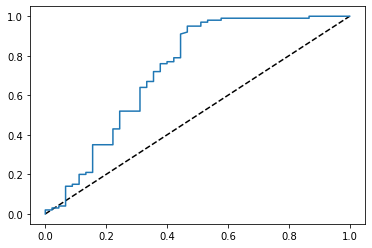

In [42]:
# auc roc
xtr,xte,ytr,yte=ttsc(xbfe1,y)
gbc2.fit(xtr,ytr)
y_pred_pro=gbc2.predict_proba(xte)[:,1]
fpr,tpr,threshold=roc_curve(yte,y_pred_pro)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr,tpr,label='LRC')
plt.show()

In [43]:
roc_auc_score(yte,y_pred_pro)

0.7287777777777777

In [44]:
# now, we'll compare all the models and the best model will be sent for deployment

In [45]:
# here , precision is important, coz we want to reduce false positive

In [46]:
# therefore, owing to auc_roc store, precision and f1_score, GradientBoosting is the best model.

In [47]:
# saving the cross valiated gbc model

In [48]:
cv_results = cross_validate(gbc2, xbfe1 ,y, cv=3, return_estimator=True)
gbc_fit = cv_results['estimator']
print(gbc_fit)

(GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.04, loss='exponential', max_depth=6,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                           min_samples_leaf=1, min_samples_split=2,
                           min_weight_fraction_leaf=0.1, n_estimators=100,
                           n_iter_no_change=None, presort='auto',
                           random_state=45, subsample=1.0, tol=0.0001,
                           validation_fraction=0.1, verbose=0,
                           warm_start=False), GradientBoostingClassifier(criterion='friedman_mse', init=None,
                           learning_rate=0.04, loss='exponential', max_depth=6,
                           max_features='sqrt', max_leaf_nodes=None,
                           min_impurity_decrease=0.0, min_impurity_split=None,
                          

In [49]:
gbc_fit=gbc_fit[0]

In [50]:
import joblib
joblib.dump(gbc_fit,'gbc_loan.pkl')

['gbc_loan.pkl']

In [51]:
# saving predictions
prediction=pd.DataFrame(crosspred)
prediction.to_csv('pred_gbc_loan.csv')